<a href="https://colab.research.google.com/github/naufalihsan/nlp-sentiment-analysis/blob/main/nlp_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

In [ ]:
import nltk

nltk.download('twitter_samples')
from nltk.corpus import twitter_samples

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


#### Load Datasets

In [ ]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [ ]:
positive_tweets = twitter_samples.strings('positive_tweets.json')

In [ ]:
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [ ]:
train_pos_tweets = positive_tweets[:4000]

In [ ]:
train_neg_tweets = negative_tweets[:4000]

In [ ]:
train_tweets = train_pos_tweets + train_neg_tweets

In [ ]:
train_labels = np.append(np.ones(len(train_pos_tweets)), np.zeros(len(train_neg_tweets)), axis = 0)

#### Preprocessing Tweet

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_tweet(tweet):
  stemmer = PorterStemmer()
  stopwords_english = stopwords.words('english')
  
  # remove stock market tickers like $GE
  tweet = re.sub(r'\$\w*', '', tweet)
  
  # remove old style retweet text "RT"
  tweet = re.sub(r'^RT[\s]+', '', tweet)

  # remove hyperlinks
  tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)

  # remove hashtags
  tweet = re.sub(r'#', '', tweet)

  # tokenize tweets
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []
  for word in tweet_tokens:
      if (word not in stopwords_english and word not in string.punctuation):
          stem_word = stemmer.stem(word)
          tweets_clean.append(stem_word)

  return tweets_clean

#### Word frequency dictionary

In [ ]:
def build_freqs(tweets, labels):
  label_list = np.squeeze(labels).tolist()
  
  freqs = {}
  for tweet, label in zip(tweets, label_list):
    for word in preprocess_tweet(tweet):
      pair = (word, label)
      freqs[pair] = freqs.get(pair, 0) + 1

  return freqs

In [ ]:
freqs = build_freqs(train_tweets, train_labels)

In [ ]:
keys = ['happi', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti','song',
        'idea', '❤', ':)', ':(', '😒', '😄', 'power', 'play', 'magnific']

data = []
for word in keys:
    pos = 0
    neg = 0

    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
      
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]

    data.append([word, pos, neg])

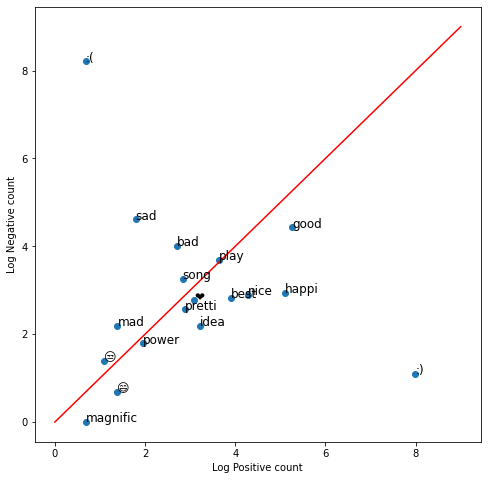

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

x = np.log([x[1] + 1 for x in data])  
y = np.log([x[2] + 1 for x in data])

ax.scatter(x, y)  

for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

ax.plot([0, 9], [0, 9], color = 'red')
plt.show()

#### Extract tweet features

In [ ]:
def tweet_to_features(tweets, labels):
  label_list = np.squeeze(labels).tolist()
  
  bias = 1
  data = list()
  for tweet, label in zip(tweets, label_list):
    pos_freq, neg_freq = 0, 0
    for word in preprocess_tweet(tweet):
      pos_freq += freqs.get((word, 1), 0)
      neg_freq += freqs.get((word, 0), 0)

    data.append([bias, pos_freq, neg_freq, label])

  columns = ['bias', 'positive', 'negative', 'sentiment']
  return pd.DataFrame(data=data, columns=columns)

In [ ]:
df = tweet_to_features(train_tweets, train_labels)

In [ ]:
df.head()

,bias,positive,negative,sentiment
0,1,3133,61,1.0
1,1,3705,444,1.0
2,1,3119,116,1.0
3,1,2975,4,1.0
4,1,3232,226,1.0


#### Visualize Logistic Regression

In [ ]:
X = df[['bias', 'positive', 'negative']].values
y = df['sentiment'].values

In [ ]:
# pretrained model theta (for learning purpose)
theta = [6.03518871e-08, 5.38184972e-04, -5.58300168e-04]

###### Plot the model alongside the data

$$ z = \theta * x = 0$$
$$ x = [1, pos, neg] $$
$$ z(\theta, x) = \theta_0+ \theta_1 * pos + \theta_2 * neg = 0 $$
$$ neg = (-\theta_0 - \theta_1 * pos) / \theta_2 $$

In [ ]:
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

In [ ]:
def direction(theta, pos):
    return pos * theta[2] / theta[1]

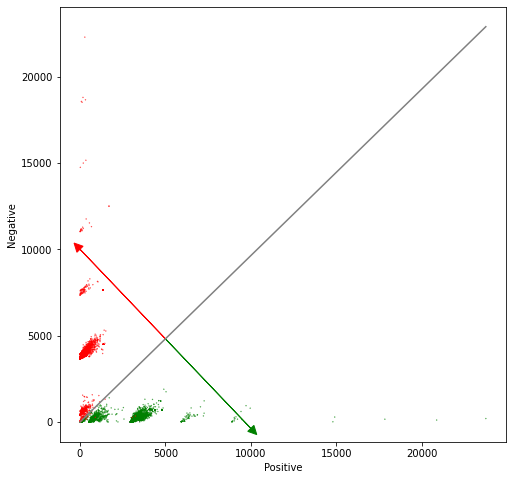

In [ ]:
colors = ['red', 'green']
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in y], s = 0.1)

plt.xlabel("Positive")
plt.ylabel("Negative")

maxpos = np.max(X[:,1])
offset = 5000

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0), neg(theta, maxpos)], color = 'gray') 

# Plot a green line pointing to the positive direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), head_width=500, head_length=500, fc='g', ec='g')

# Plot a red line pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=500, head_length=500, fc='r', ec='r')

plt.show()

#### Build Logistic Regression Model

##### Sigmoid Function

$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N \tag{1}$$

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{2}$$

In [ ]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    h = 1 / (1 + np.exp(-z))
      
    return h

##### Cost function

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{3} $$

Loss function for a single training example

$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

##### Update the weights

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{4}$$

$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$

In [ ]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    m = x.shape[0]
    
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        
        h = sigmoid(z)
        
        J = (-1 * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1-h)))) / m

        theta = theta - ((alpha * np.dot(x.T, (h - y))) / m)

    return float(J), theta

In [ ]:
J, theta = gradientDescent(X, y, np.zeros((3, 1)), 1e-9, 1500)

In [ ]:
def extract_features(tweet, freqs, preprocess_tweet=preprocess_tweet):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    word_l = preprocess_tweet(tweet)

    x = np.zeros((1, 3)) 
    
    # bias term
    x[0,0] = 1 
    
    for word in word_l:    
        x[0,1] += freqs.get((word, 1), 0)
        x[0,2] += freqs.get((word, 0), 0)
      
    return x

In [ ]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    x = extract_features(tweet, freqs)
    
    y_pred = sigmoid(np.dot(x, theta))

    return y_pred

In [ ]:
example_tweets = [
    'I am happy',
    'I am bad',
    'this movie should have been great.',
    'great',
    'great great',
    'great great great',
    'great great great great'
]

In [ ]:
for tweet in example_tweets:
    print('%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))

I am happy -> 0.519275
I am bad -> 0.494347
this movie should have been great. -> 0.515979
great -> 0.516065
great great -> 0.532096
great great great -> 0.548062
great great great great -> 0.563929
